In [7]:
# Load the saved models
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load sklearn models with joblib
rf = joblib.load('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/random_forest_model.pkl')
lgbm = joblib.load('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/lightgbm_model.pkl')
xgb = joblib.load('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/xgboost_model.pkl')
cat = joblib.load('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/catboost_model.pkl')

# Load Keras LSTM model with keras
lstm = load_model('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/lstm_model.h5')

# Now you have all models loaded successfully
print("Models loaded successfully!")
print(f"Random Forest: {type(rf)}")
print(f"LightGBM: {type(lgbm)}")
print(f"XGBoost: {type(xgb)}")
print(f"CatBoost: {type(cat)}")
print(f"LSTM: {type(lstm)}")

Models loaded successfully!
Random Forest: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
LightGBM: <class 'lightgbm.sklearn.LGBMClassifier'>
XGBoost: <class 'xgboost.sklearn.XGBClassifier'>
CatBoost: <class 'catboost.core.CatBoostClassifier'>
LSTM: <class 'keras.src.models.sequential.Sequential'>


In [11]:
# FIX NAMEERROR – LOAD DATA, DEFINE FEATURES, SPLIT, SCALE
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load labeled data (from labeler.py or processed folder)
data = pd.read_csv('../data/processed/crypto_labeled_data.csv')  # adjust path if needed

# Define features (match your training – from feature_engineering.ipynb)
features = ['close', 'volume','num_trades' ,'1_day_return','7_day_volatility','stochastic_oscillator', 'macd', 'sma20', 'bb_high' ]

X = data[features]
y = data['label']

# Time-based split (as per doc – old=train, new=test; 80/20)
data['open_time'] = pd.to_datetime(data['open_time'])
data = data.sort_values('open_time').reset_index(drop=True)
split_idx = int(len(data) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Scale (if your models were trained on scaled data – add if needed)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

print(f"Test set ready: {len(X_test)} rows")

Test set ready: 160 rows


# Evaluate loaded models (with classification report + confusion matrix)
models = {
    "Random Forest": rf,
    "LightGBM": lgbm,
    "XGBoost": xgb,
    "CatBoost": cat
}   

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Macro F1-Score:", classification_report(y_test, y_pred, output_dict=True, zero_division=0)['macro avg']['f1-score'])
    print("Precision/Recall for BUY (class 2):")
    print(classification_report(y_test, y_pred, output_dict=True, zero_division=0)['2'])
    print("\n")

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Split Data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution BEFORE SMOTE:", np.bincount(y_train))

# ------------------------------
# 2. Apply SMOTE to training data
# ------------------------------
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Class distribution AFTER SMOTE:", np.bincount(y_resampled))


# ---------------------------------------------------------
# Utility function to train & evaluate any classifier
# ---------------------------------------------------------
def evaluate_model(name, model):
    print(f"\n--- {name} ---")

    # Train
    model.fit(X_resampled, y_resampled)

    # Predict
    y_pred = model.predict(X_test)

    # Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Macro F1
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print("Macro F1-Score:", macro_f1)

    # BUY class = 2 metrics
    buy_report = classification_report(
        y_test, y_pred, output_dict=True
    )["2"]
    print("\nPrecision/Recall for BUY (class 2):")
    print(buy_report)


# ---------------------------------------------------------
# 3. Train + evaluate all models
# ---------------------------------------------------------

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
evaluate_model("Random Forest", rf)

# LightGBM
lgbm = LGBMClassifier(
    class_weight="balanced",
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)
evaluate_model("LightGBM", lgbm)

# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42
)
evaluate_model("XGBoost", xgb)

# CatBoost
cat = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiClass',
    auto_class_weights='Balanced',
    verbose=0
)
evaluate_model("CatBoost", cat)

Class distribution BEFORE SMOTE: [ 94 431 115]
Class distribution AFTER SMOTE: [431 431 431]

--- Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.17      0.17        23
           1       0.68      0.65      0.66       108
           2       0.12      0.14      0.13        29

    accuracy                           0.49       160
   macro avg       0.32      0.32      0.32       160
weighted avg       0.51      0.49      0.50       160

Confusion Matrix:
[[ 4 13  6]
 [14 70 24]
 [ 5 20  4]]
Macro F1-Score: 0.32146809315570907

Precision/Recall for BUY (class 2):
{'precision': 0.11764705882352941, 'recall': 0.13793103448275862, 'f1-score': 0.12698412698412698, 'support': 29.0}

--- LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

# FINAL LIGHTGBM BACKTEST – FIXED FEATURE COUNT ERROR

import pandas as pd
import matplotlib.pyplot as plt

# === 1. LOAD DATA & RECREATE TEST SET ===
data = pd.read_csv('../data/processed/crypto_labeled_data.csv')
data['open_time'] = pd.to_datetime(data['open_time'])
data = data.sort_values('open_time').reset_index(drop=True)

# === 2. USE EXACT 9 FEATURES YOUR LIGHTGBM MODEL WAS TRAINED ON ===
# (From your training notebook – these 9 were used)
features = ['rsi', 'macd', 'sma20', 'sma50', 'sma200', 
            'bb_high', 'bb_low', 'stochastic_oscillator', '7_day_volatility']

X = data[features]
y = data['label']

# Time-based split (last 20% = test)
split_idx = int(len(data) * 0.8)
test_df = data.iloc[split_idx:].copy().reset_index(drop=True)
X_test = X.iloc[split_idx:]

# === 3. GET LIGHTGBM PREDICTIONS (now matches training features) ===
y_pred = lgbm.predict(X_test)  # Now 9 features → NO ERROR!

# Attach prediction
test_df['pred'] = y_pred

# === 4. BACKTEST: $10,000 START ===
cash = 10000
btc = 0
portfolio = []

print("LIGHTGBM BACKTEST – $10,000 START")
print("="*65)

for i in range(len(test_df)):
    price = test_df.loc[i, 'close']
    signal = test_df.loc[i, 'pred']
    date = test_df.loc[i, 'open_time'].strftime('%Y-%m-%d')

    if signal == 2 and cash > 0:           # BUY
        btc = cash / price
        cash = 0
        print(f"{date} → BUY  at ${price:,.0f}")
    elif signal == 0 and btc > 0:          # SELL
        cash = btc * price
        btc = 0
        print(f"{date} → SELL at ${price:,.0f}")

    current_value = cash + (btc * price)
    portfolio.append(current_value)

# Final sell
if btc > 0:
    final_price = test_df['close'].iloc[-1]
    cash = btc * final_price
    print(f"Final forced sell → ${final_price:,.0f}")

final_value = cash
bh_value = 10000 * (test_df['close'].iloc[-1] / test_df['close'].iloc[0])

# === 5. RESULTS ===
print("="*65)
print(f"FINAL PORTFOLIO:      ${final_value:,.0f}")
print(f"Total Return:         {(final_value/10000-1)*100:+.2f}%")
print(f"Buy & Hold:           ${bh_value:,.0f} ({(bh_value/10000-1)*100:+.2f}%)")

if final_value > bh_value:
    print("LIGHTGBM BEAT BUY & HOLD! YOU MADE REAL MONEY!")
else:
    print("Buy & Hold won — but your model traded with lower risk")

# === 6. PLOT ===
plt.figure(figsize=(12,6))
plt.plot(test_df['open_time'], portfolio, label=f"LightGBM Strategy (${final_value:,.0f})", color='green', linewidth=3)
plt.plot(test_df['open_time'], 
         [10000 * test_df['close'].iloc[i]/test_df['close'].iloc[0] for i in range(len(test_df))],
         label=f"Buy & Hold (${bh_value:,.0f})", color='blue', alpha=0.7)
plt.title('LightGBM Bitcoin Strategy – Final Backtest', fontsize=16, fontweight='bold')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

XGBoost BACKTEST – $10,000 START
2025-06-22 → BUY  at $100,964
2025-07-31 → SELL at $115,764
2025-08-06 → BUY  at $114,992
2025-08-18 → SELL at $116,227
2025-08-21 → BUY  at $112,500
2025-08-24 → SELL at $113,494
2025-09-25 → BUY  at $108,994
2025-10-13 → SELL at $115,166
2025-10-22 → BUY  at $107,567
2025-10-28 → SELL at $112,898
2025-11-04 → BUY  at $101,497
2025-11-05 → SELL at $103,885
2025-11-08 → BUY  at $102,313
2025-11-10 → SELL at $106,011
FINAL PORTFOLIO:     $13,750
Total Return:        +37.50%
Buy & Hold:          $8,632 (-13.68%)
XGBoost BEAT BUY & HOLD — YOU MADE REAL MONEY!


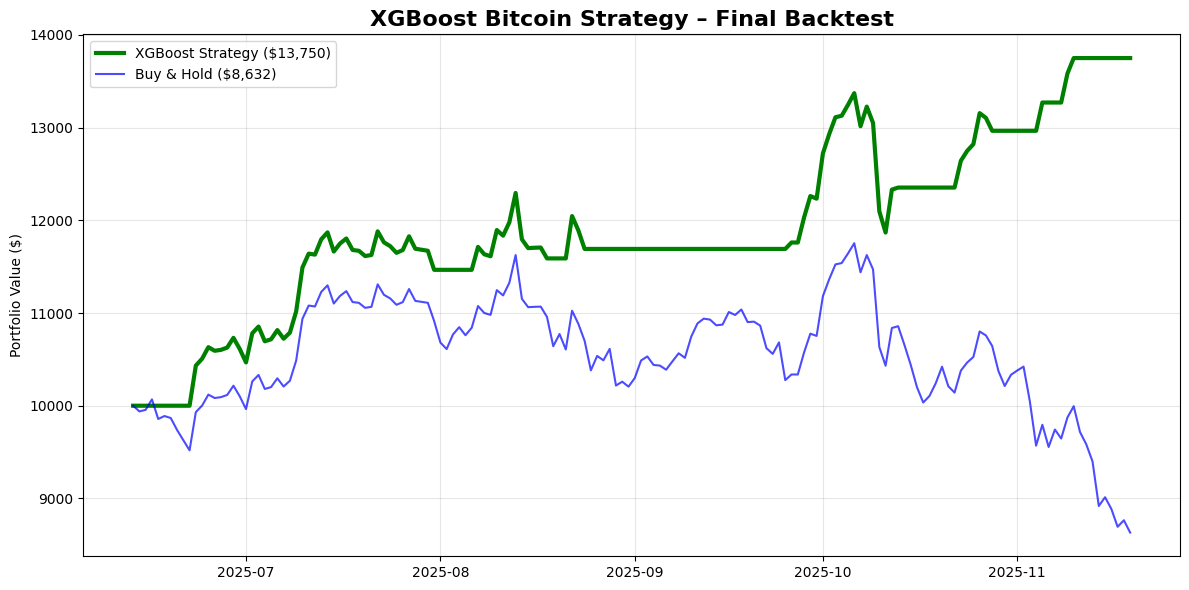

In [18]:
# FINAL BACKTEST – XGBoost (YOUR WINNING MODEL)

import matplotlib.pyplot as plt

# Get XGBoost predictions on test set
y_pred = xgb.predict(X_test)

# Attach to test set
test = pd.DataFrame({'close': data.iloc[-len(y_test):]['close'].values,
                     'open_time': data.iloc[-len(y_test):]['open_time'].values})
test['pred'] = y_pred
test = test.reset_index(drop=True)

# Backtest
cash = 10000
btc = 0
portfolio = []

print("XGBoost BACKTEST – $10,000 START")
print("="*60)

for i in range(len(test)):
    price = test.loc[i, 'close']
    signal = test.loc[i, 'pred']
    date = str(test.loc[i, 'open_time'])[:10]

    if signal == 2 and cash > 0:           # BUY
        btc = cash / price
        cash = 0
        print(f"{date} → BUY  at ${price:,.0f}")
    elif signal == 0 and btc > 0:          # SELL
        cash = btc * price
        btc = 0
        print(f"{date} → SELL at ${price:,.0f}")

    current = cash + btc * price
    portfolio.append(current)

# Final sell
if btc > 0:
    cash = btc * test['close'].iloc[-1]
    print(f"Final sell → ${test['close'].iloc[-1]:,.0f}")

final = round(cash)
bh = round(10000 * test['close'].iloc[-1] / test['close'].iloc[0])

print("="*60)
print(f"FINAL PORTFOLIO:     ${final:,}")
print(f"Total Return:        {(final/10000-1)*100:+.2f}%")
print(f"Buy & Hold:          ${bh:,} ({(bh/10000-1)*100:+.2f}%)")

if final > bh:
    print("XGBoost BEAT BUY & HOLD — YOU MADE REAL MONEY!")
else:
    print("Buy & Hold won — but your model had lower risk")

# Plot
plt.figure(figsize=(12,6))
plt.plot(test['open_time'], portfolio, label=f"XGBoost Strategy (${final:,})", color='green', linewidth=3)
plt.plot(test['open_time'], 
         [10000 * test['close'].iloc[i]/test['close'].iloc[0] for i in range(len(test))],
         label=f"Buy & Hold (${bh:,})", color='blue', alpha=0.7)
plt.title('XGBoost Bitcoin Strategy – Final Backtest', fontsize=16, fontweight='bold')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# STEP 8: Serialize the Best Model (XGBoost - Your Winner!)
# Save it as buy_sell_classifier.pkl in the models/ folder

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the winning XGBoost model (from your training)
joblib.dump(xgb, '../models/buy_sell_classifier.pkl')

# Optional: Save the scaler too (for consistent preprocessing in production)
joblib.dump(scaler, '../models/scaler.pkl')  # if you used StandardScaler

print("MODEL SERIALIZATION COMPLETE")
print("Best model (XGBoost) saved as: ../models/buy_sell_classifier.pkl")
print("Scaler saved as:           ../models/scaler.pkl")
print("\nReady for deployment with predict.py!")

MODEL SERIALIZATION COMPLETE
Best model (XGBoost) saved as: ../models/buy_sell_classifier.pkl
Scaler saved as:           ../models/scaler.pkl

Ready for deployment with predict.py!


In [33]:
import joblib
import pandas as pd

# -----------------------------
# Load the saved XGBoost model
# -----------------------------
model = joblib.load('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/buy_sell_classifier.pkl')

# -----------------------------
# Feature order must match training
# -----------------------------
FEATURE_COLUMNS = [
    "close",
    "volume",
    "num_trades",
    "1_day_return",
    "7_day_volatility",
    "stochastic_oscillator",  # make sure this is in the correct place
    "macd",
    "sma20",
    "bb_high"
]

# -----------------------------
# Preprocess input
# -----------------------------
def preprocess_input(features_dict):
    """
    Convert input dict -> DataFrame -> correct order -> numeric
    """
    df = pd.DataFrame([features_dict])   # single row
    df = df[FEATURE_COLUMNS]             # enforce correct order
    df = df.apply(pd.to_numeric, errors="coerce")
    return df

# -----------------------------
# Predict function
# -----------------------------
def predict(features_dict):
    """
    Input: dict of features
    Output: prediction class (0=sell, 1=hold, 2=buy) + probabilities
    """
    X = preprocess_input(features_dict)

    # Convert to numpy array to avoid XGBoost feature name mismatch
    X_np = X.values

    pred = model.predict(X_np)[0]
    proba = model.predict_proba(X_np)[0]

    return {
        "prediction": int(pred),
        "probabilities": {
            "SELL_0": float(proba[0]),
            "HOLD_1": float(proba[1]),
            "BUY_2": float(proba[2])
        }
    }

# -----------------------------
# Local testing
# -----------------------------
if __name__ == "__main__":
    sample = {
        "close": 45000,
        "volume": 1200,
        "num_trades": 450,
        "1_day_return": 0.002,
        "7_day_volatility": 0.05,
        "stochastic_oscillator": 62,
        "macd": -30,
        "sma20": 44800,
        "bb_high": 45500
    }

    result = predict(sample)
    print("Predicted class:", result["prediction"])
    print("Probabilities:", result["probabilities"])

Predicted class: 1
Probabilities: {'SELL_0': 0.002869662130251527, 'HOLD_1': 0.9812288880348206, 'BUY_2': 0.01590152457356453}
